In [1]:
import scipy
import scipy.fftpack
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
from pathlib import Path
import pickle
import timeit
import sys, os

import pycoss.surface as surface
import pycoss.surface.interp.FFT as FFT
from pycoss.surface.helpers import *
from pycoss.surface.integrators import *
import pycoss.surface.helpers.plotting as plotting

In [2]:
np.seterr(all='raise')
import warnings
warnings.filterwarnings(action="error", category=np.ComplexWarning)

## Parameters

In [3]:
sim_name = 'KE_surface_open'
output_folder = '../output'
scenario_name = 'test_scenario'
run_name = 'test'

dt = 1e-3
integrator = 'integrator_KE_SO3'

In [4]:
Lu0 = 1
Lv0 = 2
dim = 3

shell_width = 0.1

Nmu = 20
Nmv = 20

Mmu_render = Nmu*4
Mmv_render = Nmv*4

Mmu_save = Nmu*2
Mmv_save = Nmv*2

random_seed = 332325

# Simulation parameters

T = 0.01
taylor_tol = 1e-2

# Misc

N_save = 10
N_clock = 100
N_integrator_trials = int(1e3)

In [5]:
# Load arguments if running as a script
if sys.argv[1] == "args":
    params_pkl_path = sys.argv[2]
    args_params = pickle.load(open(params_pkl_path, 'rb'))

    for param_k, param_v in args_params.items():
        globals()[param_k] = param_v

## Initial conditions

In [6]:
if random_seed != -1:
    np.random.seed(random_seed)

In [7]:
path_handler = surface.interp.cheb.ChebHandler(dim, Nmu, Nmv, Lu0, Lv0, mpmath_dps=-1)
path_handler_render = surface.interp.cheb.ChebHandler(dim, Mmu_render, Mmv_render, Lu0, Lv0, mpmath_dps=-1)

In [8]:
thu0 = np.zeros((3, Nmu, Nmv))
thv0 = np.zeros((3, Nmu, Nmv))
piu0 = np.zeros((3, Nmu, Nmv))
piv0 = np.zeros((3, Nmu, Nmv))

thu0[1] = 1
thv0[2] = 1

piu0[1] = 0
piv0[0] = 0

Fr_uv0 = np.eye(4)

R, E = reconstruct_surface(thu0, thv0, piu0, piv0, Fr_uv0, Mmu_render, Mmv_render, Mmu_save, Mmv_save, path_handler_render)

In [9]:
X_path_handler = pycoss.surface.interp.cheb.ChebHandler((4,4), Nmu, Nmv, Lu0, Lv0, mpmath_dps=-1)

piu0_hat = hat_vec_to_mat(piu0)
piv0_hat = hat_vec_to_mat(piv0)

Xu = construct_se3_elem(thu0, piu0_hat)
Xv = construct_se3_elem(thv0, piv0_hat)

dv_Xu = X_path_handler.diffv_f(Xu)
du_Xv = X_path_handler.diffu_f(Xv)
ad_Xu_Xv = np.einsum('ijuv,jkuv->ikuv', Xu, Xv) - np.einsum('ijuv,jkuv->ikuv', Xv, Xu)

np.max(np.abs((du_Xv + ad_Xu_Xv) - dv_Xu))

8.526512829121202e-14

(<Figure size 1000x1000 with 1 Axes>, <Axes3DSubplot:>)

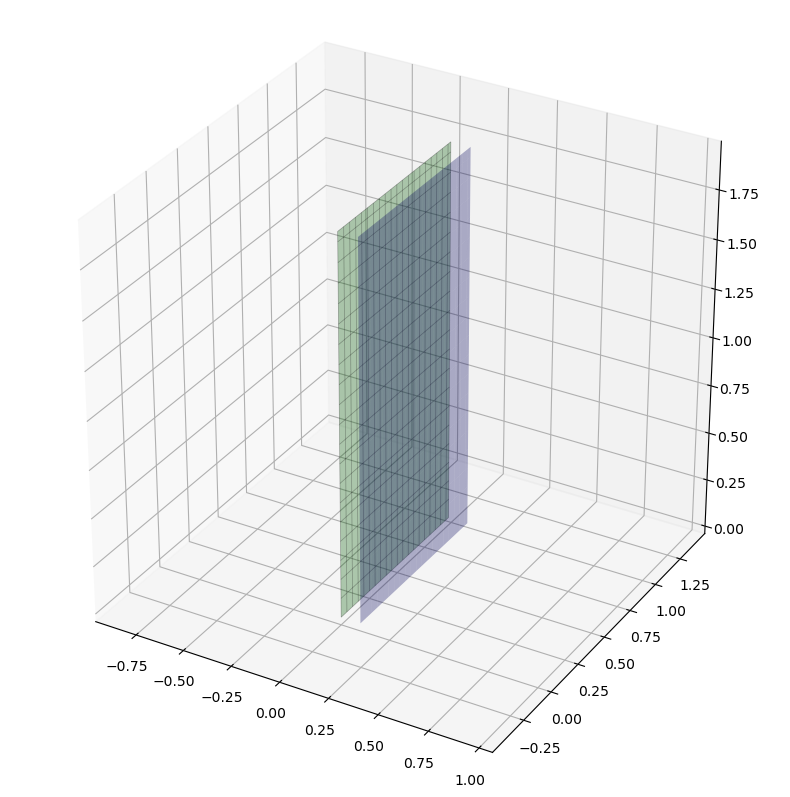

In [10]:
fig = plt.figure(figsize=(10,10))
plotting.plot_surface(R, E, shell_width, fig=fig)
plt.close(fig)

In [11]:
X_path_handler = pycoss.surface.interp.cheb.ChebHandler((4,4), Nmu, Nmv, Lu0, Lv0, mpmath_dps=-1)

piu0_hat = hat_vec_to_mat(piu0)
piv0_hat = hat_vec_to_mat(piv0)

Xu = construct_se3_elem(thu0, piu0_hat)
Xv = construct_se3_elem(thv0, piv0_hat)

dv_Xu = X_path_handler.diffv_f(Xu)
du_Xv = X_path_handler.diffu_f(Xv)
ad_Xu_Xv = np.einsum('ijuv,jkuv->ikuv', Xu, Xv) - np.einsum('ijuv,jkuv->ikuv', Xv, Xu)

np.max(np.abs((du_Xv + ad_Xu_Xv) - dv_Xu))

8.526512829121202e-14

## Define kinematics

In [12]:
grid_U, grid_V = path_handler.grid

In [13]:
ti = 0

rand_V_var = 1e0
rand_Omg_var = 1e0

N_rand_V_t = 5
N_rand_V_u = 5
N_rand_V_v = 5

N_rand_Omg_t = 5
N_rand_Omg_u = 5
N_rand_Omg_v = 5

In [14]:
Nt = int(np.round(T/dt))
ts = np.linspace(0, T, Nt)
rand_V_coeffs = np.zeros((3, N_rand_V_u, N_rand_V_v, Nt))
rand_Omg_coeffs = np.zeros((3, N_rand_Omg_u, N_rand_Omg_v, Nt))

for di in range(dim):
    for i in range(N_rand_V_u):
        for j in range(N_rand_V_v):
            rand_V_coeffs[di,i,j] = rand_V_var * np.random.normal()
            rand_Omg_coeffs[di,i,j] = rand_Omg_var * np.random.normal()

            for k in range(N_rand_V_t):
                rand_V_coeffs[di,i,j] += rand_V_var * np.random.normal() * np.sin( (k - 0.5)*np.pi*ts/T ) / ( (k-0.5) * np.pi )
                rand_Omg_coeffs[di,i,j] += rand_Omg_var * np.random.normal() * np.sin( (k - 0.5)*np.pi*ts/T ) / ( (k-0.5) * np.pi )

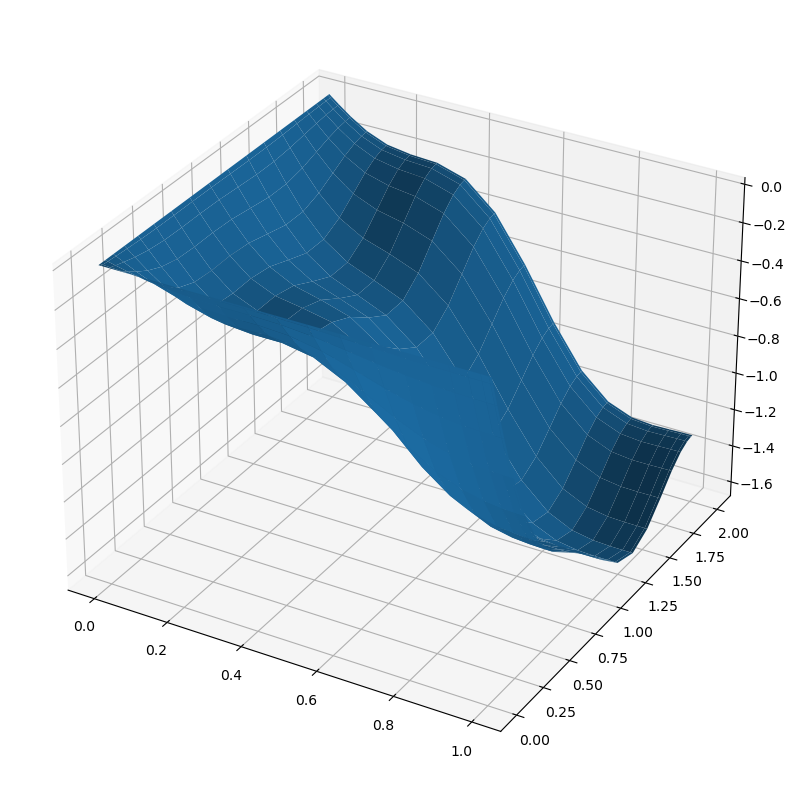

In [15]:
ti = 0
out = np.zeros((3, Nmu, Nmv))
for di in range(dim):
    for i in range(N_rand_V_u):
        for j in range(N_rand_V_v):
            out[di] += rand_V_coeffs[di,i,j,ti] * np.sin((i - 0.5)*np.pi*grid_U/Lu0) * np.sin((j - 0.5)*np.pi*grid_V/Lv0) / ( (i-0.5) * (j - 0.5) * np.pi**2 )
        
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(grid_U, grid_V, out[0])
plt.close(fig)

In [16]:
def compute_V(t, thu, thv, piu, piv, out=None):
    ti = int(Nt * t / T)
    out[:] = 0
    for di in range(dim):
        for i in range(N_rand_V_u):
            for j in range(N_rand_V_v):
                out[di] += rand_V_coeffs[di,i,j,ti] * np.sin((i - 0.5)*np.pi*grid_U/Lu0) * np.sin((j - 0.5)*np.pi*grid_V/Lv0) / ( (i-0.5) * (j - 0.5) * np.pi**2 )

    return out

def compute_Omg(t, thu, thv, piu, piv, out=None):
    ti = int(Nt * t / T)
    out[:] = 0
    for di in range(dim):
        for i in range(N_rand_Omg_u):
            for j in range(N_rand_Omg_v):
                out[di] += rand_Omg_coeffs[di,i,j,ti] * np.sin((i - 0.5)*np.pi*grid_U/Lu0) * np.sin((j - 0.5)*np.pi*grid_V/Lv0) / ( (i-0.5) * (j - 0.5) * np.pi**2 )

    return out

## Simulate

In [17]:
params = {
    'T' : T,
    'dt' : dt,
    'taylor_tol' : taylor_tol,
    
    'path_handler' : path_handler,
    'path_handler_render' : path_handler_render,
    
    'thu0' : thu0,
    'thv0' : thv0,
    'piu0' : piu0,
    'piv0' : piv0,
    'Fr0_uv0' : Fr_uv0,
    
    'V' : compute_V,
    'Omg' : compute_Omg,
    
    'N_save' : N_save,
    'Mmu_save' : Mmu_save,
    'Mmv_save' : Mmv_save,
    
    'N_clock' : N_clock,
    
    'save_ts' : False,
}

In [18]:
params['integrator'] = globals()[integrator]
sim_res = surface.sim.KE_simulate(params)

## Saving results

In [19]:
data_path = Path(output_folder, sim_name, scenario_name, run_name)
data_path.mkdir(parents=True, exist_ok=True)

figs_path = Path(data_path, 'figs')
figs_path.mkdir(parents=True, exist_ok=True)

In [20]:
pickle.dump(sim_res, open(Path( data_path, 'sim_res.pkl' ), 'wb'))

In [21]:
_params = dict.copy(params)

del _params['path_handler']
del _params['path_handler_render']
del _params['V']
del _params['Omg']
_params['integrator'] = integrator

pickle.dump(_params, open(Path( data_path, 'params.pkl' ), 'wb'))

### Stats

In [22]:
thu = sim_res['thu']
thv = sim_res['thv']
piu = sim_res['piu']
piv = sim_res['piv']
t = 0
dt = params['dt']
taylor_tol = params['taylor_tol']

func = globals()[integrator]
lfunc = lambda: func(thu, thv, piu, piv, t, dt, compute_V, compute_Omg, path_handler,
                 taylor_tol, pre_transform=None, post_transform=None)
integrator_time_single_step = timeit.timeit(lfunc, number=N_integrator_trials)/N_integrator_trials
integrator_time = integrator_time_single_step * sim_res['Nt']
integrator_time /= 60**2

In [23]:
stats = {
    'integrator_time' : integrator_time,
    'integrator_time_single_step' : integrator_time_single_step,
    'sim_run_time' : sim_res['sim_run_time'],
    'sim_run_time2' : sim_res['sim_run_time2'],
}

pickle.dump(stats, open(Path( data_path, 'stats.pkl' ), 'wb'))

In [24]:
with open(Path( data_path, 'stats.txt' ), 'w') as f:
    for k, v in stats.items():
        f.write('%s: %s\n' % (k,v))

### Figures

In [25]:
plt.rcParams['figure.facecolor'] = 'white'

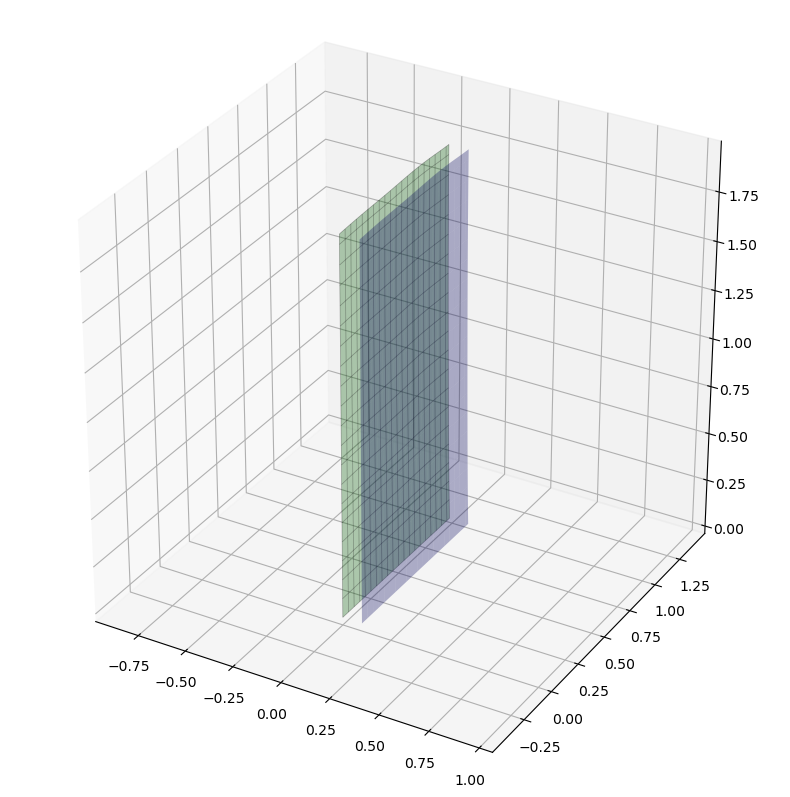

In [26]:
fig = plt.figure(figsize=(10,10))
R = sim_res['Rf']
E = sim_res['Ef']
plotting.plot_surface(R, E, shell_width, fig=fig)
fig.savefig(Path(figs_path, 'Rf.png'))
plt.close(fig)

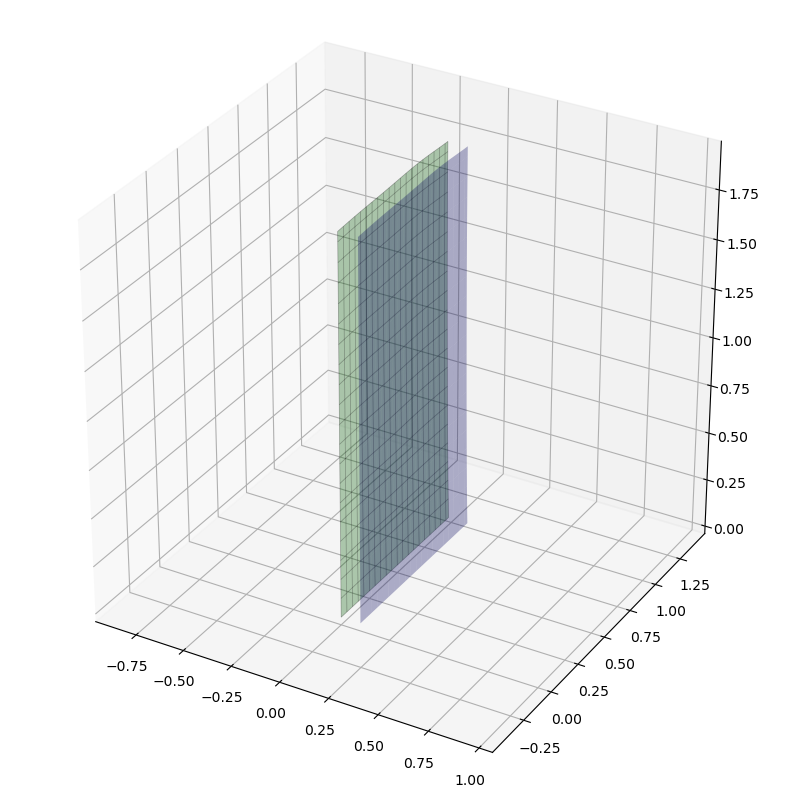

In [27]:
fig, _ = plotting.vid_surface(sim_res['saved_R'], sim_res['saved_E'], shell_width, save_name=Path(figs_path, 'video.mp4'))
plt.close(fig)

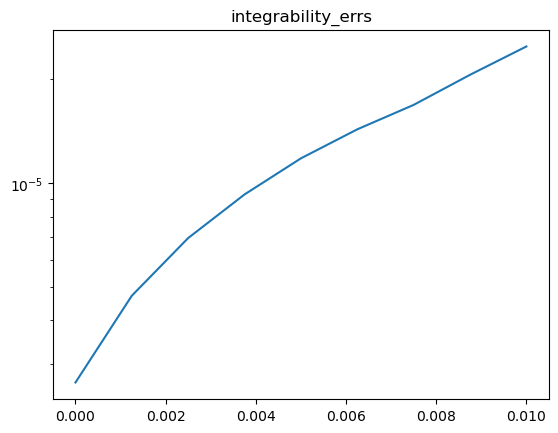

In [28]:
fig, ax = plt.subplots()
ax.set_title('integrability_errs')
ts = np.linspace(0, T, len(sim_res['integrability_errs']))
ax.plot(ts, sim_res['integrability_errs'])
ax.set_yscale('log')
fig.savefig(Path( figs_path, 'integrability_errs.png' ))
plt.show()
plt.close()